# Computed Tomography - Reconstruction

<div>
    <img src="./res/ct_scanner.png" height="500" width="650"/>
    <img src="./res/scanner_pos.png" height="500" width="650"/>
</div>
<a href="https://plus.maths.org/content/saving-lives-mathematics-tomography">Ref: plus.maths.org</a>

#### Radon function - Relationship between initial and attenuated photon intensity

$ln(I_{0}/I) = \int{\mu(x, y) ds}$

=> $I = I_{0} e^{- \int{\mu(x, y) ds}}$

- $I$ = Resulting intensity after attenuation
- $I_{0}$ = Initial intensity from the projector
- $\mu(x, y )$ - Attenuation coefficient

=> $I = I_{0} e^{- R}$ where we define $R = \int{\mu(x, y) ds}$ and it stands for a single projection of light beams 
passing through the object and being projected on the scanner. Taking the rotation of the scanner into account we 
consider the formulation of line integrals as,

<div>
    <img src="./res/scan_projection.png" height=400, width=900/>
</div>

$\mu(x\prime, y\prime) = \int{\mu((x \cos{\theta} + y \sin{\theta}), (-x \sin{\theta} + y \cos{\theta})) dx dy}$

# Abstract Dataset

An assumed 2D cross section of a human body or a material. Circular section has higher density (attenuation coefficient) 
such as more photons are absorbed while passing through the same.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from framework.gen import DataGenerator
from framework.recon import Reconstructor

%matplotlib inline
%load_ext autoreload
%autoreload 2

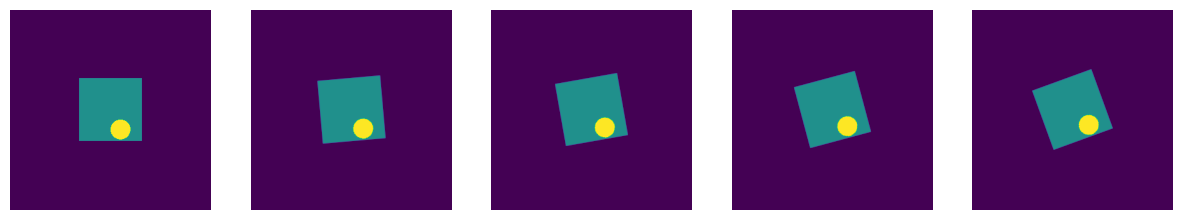

In [7]:
# Plot our abstract object dataset
generator: DataGenerator = DataGenerator.from_config()
generator.plot_samples()

# Projection - Line Integrals

NOTE: What we are seeing above is actually the attenuation profile $\mu(x, y)$ for our abstract object. For each 
rotation angle $\theta$ we want to derive the sinogram $\ln({I_0}/I)$.

For each rotation angle, the sinogram is the line integral of the attenuation function: $\int{\mu(x, y) {ds}}$

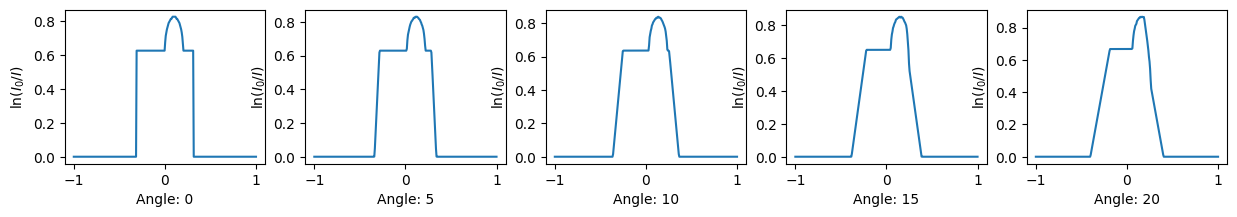

In [13]:
# Plot the projections for our abstract object dataset
recon: Reconstructor = Reconstructor(
    dataset=list(generator()), 
    rotation_profile=(
        generator.angle_start, 
        generator.angle_end, 
        generator.rotation_interval
    )
)
recon.plot_projections()

# Sinogram

# TODO

NOTE: The `sinograms` array now has 36 sinograms or $p(r, \theta)$ values for each single rotation of our total 36 
rotations. Let's plot some of them. We have considered rotations in the range from 0 to 180 degrees with the interval of 
5 degrees. We would plot five of them and try to develop some intuition.

NOTE: Now we plot the first rotation and corresponding sinogram side by side to build an intuition.

NOTE: We started with the assumption that the circular portion is the denser portion of the object (may be a bone if 
we imagine it as a section of the human body and rest of the inner square is flesh). That means the circular portion 
has higher attenuation coefficient $\mu$, means it obstructs more light then the rest of the square. 

Also we need to keep in mind that the right side curves are showing us the sinogram $\ln({I_0}/I)$. So if the circular 
portion stops more light then it would result in a higher value of $\ln({I_0}/I)$, which is exactly what we are seeing 
here in the first case. We see that for the padded portion we have constant 0 values, a bit higher values for the beams 
that passed through the object and then a spike for the circular portion. In the second sample we see the similar result 
when the sensor is rotated by 10 degrees and we have subsequent rotated samples and their corresponding sinograms in our 
dataset. We now plot all the sinograms and understand, why we call them sinograms on the first place.

NOTE: This plot is called sinogram because each data point from our computation of $\int{f(x, y) {ds}}$ for all the 
given rotatory angles appears like sine wave in this plot. When we do a CT-Scan of a patient this is what we generate. 
And this becomes input for reconstruction of the body section.

# Reconstruction - Regular Back Projection

We have understood how regular back projections works in the notes. Basically, we are computing the following function.

$f_{BP}(x, y) = \int_{0}^\pi{p (x \cos{\theta} + y \sin{\theta}, \theta) d\theta}$

We would use `RectBivariateSpline` interpolation function to interpolate data for the resulting image. We start by 
inspecting some dimensions that we are dealing with.

In [15]:
print(f'Dimension of distance r for the scanner: {lsp.shape}')
print(f'Number of rotation angles: {angles.shape}')
print(f'Dimension of resulting sinogram: {sinograms.transpose().shape}')
print(f'Shape of the meshgrid: ({xv.shape}, {yv.shape})')

Dimension of distance r for the scanner: (320,)
Number of rotation angles: (36,)
Dimension of resulting sinogram: (320, 36)
Shape of the meshgrid: ((320, 320), (320, 320))


In [16]:
# Define back projection function
@np.vectorize
def recon_reg_back_projection(x: float, y: float) -> np.ndarray:
    """Implements reconstruction using regular back projection"""
    # We compute difference between each angle
    d_angles: np.ndarray = np.diff(angles)[0]
    projection_interpolate: Callable[[float, float], float] = RectBivariateSpline(x=lsp, y=angles, z=sinograms.transpose())
    return projection_interpolate(x * np.cos(angles) + y * np.sin(angles), angles, grid=False).sum() * d_angles    

In [17]:
# Regular Back Projection
recon_bp: np.ndarray = recon_reg_back_projection(xv, yv)

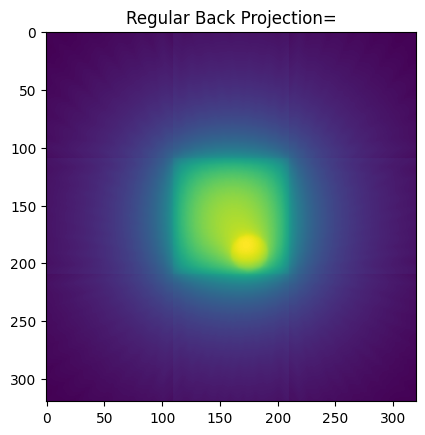

In [18]:
# Plot Regular Back Projection
plt.imshow(recon_bp);
plt.title('Regular Back Projection=');

NOTE: We observe that regular back projection did a descent job but the reconstruction is not very clear. The 
attenuation profile is somewhat accurate estimated but we can still do better. And to do better we need to make use 
of filtered back projection.

# Reconstruction - Filtered Back Projection

In [19]:
from scipy.fft import fft, ifft

NOTE: We start with taking the fourier transform of the sinogram, which is $p(r, \theta)$. More specifically we'd get 
individual fourier transform of each single angle $\theta$. In our mathematical formulation, we have denoted this as 
$P(\nu, \theta)$. The transpose of our sinogram orients angles column wise. Hence, we would take the fft from the 
perspective of axis=0.

In [20]:
print(f'Sinogram has shape: {sinograms.transpose().shape}')

Sinogram has shape: (320, 36)


In [21]:
# Fourier transform of the 1D sinogram function
p_ft: np.ndarray = fft(sinograms.transpose(), axis=0)

In [22]:
# Extract frequencies to be used as low pass filter
nu_filter: np.ndarray = np.fft.fftfreq(p_ft.shape[0], d=np.diff(lsp)[0])
print(f'Filter shape: {nu_filter.shape}')

Filter shape: (320,)


In [23]:
# Perform filtering. This filtered fourier transform relates to the 2D fourier transform of the attenuation function.
integrand: np.ndarray = np.abs(nu_filter).transpose() * p_ft.T
print(f'Integrand has shape: {integrand.shape}')

Integrand has shape: (36, 320)


In [24]:
# Take inverse fourier transform of the filtered fourier transform of the sinogram and consider only the real part.
ifft_p: np.ndarray = np.real(ifft(integrand.T, axis=0))
print(f'Inverse fourier transform of the attenuation function has shape: {ifft_p.shape}')

Inverse fourier transform of the attenuation function has shape: (320, 36)


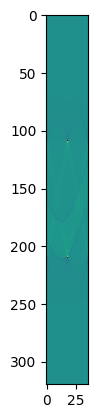

In [25]:
plt.imshow(ifft_p)

In [26]:
# Define filtered back projection function
@np.vectorize
def recon_filtered_back_projection(x: float, y: float) -> np.ndarray:
    """Implements reconstruction using regular back projection"""
    # We compute difference between each angle
    d_angles: np.ndarray = np.diff(angles)[0]
    projection_interpolate: Callable[[float, float], float] = RectBivariateSpline(x=lsp, y=angles, z=ifft_p)
    return projection_interpolate(x * np.cos(angles) + y * np.sin(angles), angles, grid=False).sum() * d_angles  

In [27]:
recon_filtered_bp: np.ndarray = recon_filtered_back_projection(xv, yv)

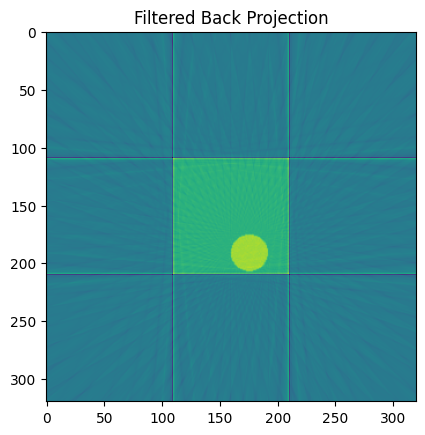

In [28]:
# Plot Regular Back Projection
plt.imshow(recon_filtered_bp);
plt.title('Filtered Back Projection');